# Humanitarian Task Image Classification 

In this notebook, we use a pre-trained Inception v3 image classifier to classify tweet images for humanitarian task classification.

In [2]:
!pip install stanza

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!conda config --append channels conda-forge

In [4]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.8 MB 169 kB/s eta 0:00:01


In [2]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 33.8 MB 3.7 MB/s eta 0:00:01


In [1]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import csv
import math
import pickle
import stanza
import cv2
import copy
import seaborn as sns
import time
from PIL import Image
from sklearn import metrics

from torch.utils.data.sampler import BatchSampler, RandomSampler, Sampler, \
    SequentialSampler, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.nn import functional
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, \
    precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict, Counter
from json import load, dump
from torchvision import datasets, models, transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
# torch.cuda.device_count(),\
torch.cuda.get_device_name(0),\
# torch.cuda.get_device_name(1)

('Quadro RTX 6000',)

## 1. Load Datafiles

In [4]:
import os
os.getcwd()
# os.chdir("d:\\Spring 2023\\7643 Deep Learning\\Project\\multimodality-language-disparity\\image-models\\")

'/storage/home/hcocice1/sarora320'

In [5]:
# %cd /content/drive/MyDrive/Deep Learning Project/multimodality-language-disparity/

In [6]:
train_split_df = pd.read_csv('../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv', sep='\t')

In [7]:
train_split_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive


In [8]:
labels = Counter(train_split_df['label'])
labels

Counter({'not_humanitarian': 5260,
         'other_relevant_information': 3294,
         'infrastructure_and_utility_damage': 1905,
         'vehicle_damage': 134,
         'affected_individuals': 424,
         'rescue_volunteering_or_donation_effort': 2323,
         'injured_or_dead_people': 244,
         'missing_or_found_people': 24})

In [9]:
label_map = {
    'affected_individuals': 0,
    'infrastructure_and_utility_damage': 1,
    'not_humanitarian': 2,
    'other_relevant_information': 3,
    'rescue_volunteering_or_donation_effort': 4,
    'vehicle_damage': 1,
    'injured_or_dead_people': 0,
    'missing_or_found_people': 0
}

In [10]:
len(train_split_df)

13608

In [10]:
'../sverma324/data/crisis-mmd/{}'.format(train_split_df.iloc[4, 4])

'../sverma324/data/crisis-mmd/data_image/california_wildfires/10_10_2017/917793137925459968_2.jpg'

In [11]:
def image_transform(image):

    h, w, _ = image.shape
    target_len = 299
    padded_image = np.zeros((target_len, target_len, 3)).astype(int)


    if w > h:
        # Resize to [] x 299
        image = cv2.resize(image, (target_len, math.floor(h / (w / target_len))))
        short_len = image.shape[0]

        # Pad to 299 x 299
        padded_image[math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :, :] = image
    else:
        # Resize to 299 x []
        image = cv2.resize(image, (math.floor(w / (h / target_len)), target_len))
        short_len = image.shape[1]

        # Pad to 299 x 299
        padded_image[:, math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :] = image
    
    return padded_image

image = cv2.imread('../sverma324/data/crisis-mmd/{}'.format(train_split_df.iloc[3, 4]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image

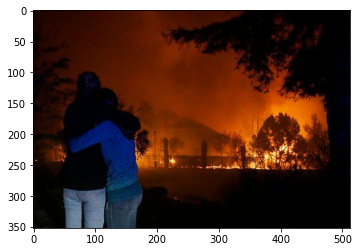

In [12]:
plt.imshow(image)
plt.show()

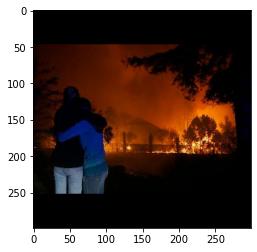

In [13]:
plt.imshow(image_transform(image))
plt.show()

In [14]:
class ImageDataset(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize one dimension of image to 299
        image = image_transform(image)
        
        # Swap axis
        image = image.transpose((2, 0, 1))
        
        # Normalize the image
        image = image / 255
        image = torch.from_numpy(image)
        image = self.normalize(image).float()
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        return image, label

In [15]:
train_dataset = ImageDataset('../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             '../sverma324/data/crisis-mmd')

In [16]:
for i in train_dataset:
    print(i[0].shape, i[1])
    break

torch.Size([3, 299, 299]) 2


In [17]:
len(train_dataset)

13608

## Fine Tuning Resnet-18

In [18]:
class ImageDataset(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        return image, label

In [19]:
os.getcwd()

'/storage/home/hcocice1/sarora320'

In [20]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDataset('../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             '../sverma324/data/crisis-mmd')
dev_dataset = ImageDataset('../sverma324/data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             '../sverma324/data/crisis-mmd')
test_dataset = ImageDataset('../sverma324/data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             '../sverma324/data/crisis-mmd')

In [21]:
tsv_file = '../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv'
a = pd.read_csv(tsv_file, sep='\t')
a['label_text_image'].value_counts()

Negative    7482
Positive    6126
Name: label_text_image, dtype: int64

In [39]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [30]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, torch.max(inputs), labels)
    break

torch.Size([32, 3, 224, 224]) tensor(2.6400) tensor([3, 4, 4, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 2, 4, 3, 2, 4, 1, 3, 1, 3, 4,
        4, 1, 2, 2, 2, 2, 3, 1])


In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=20):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

for name, param in model_ft.named_parameters():
    
    if name not in set(['fc.weight', 'fc.bias']):
        param.requires_grad = False
    else:
        param.requires_grad = True
model_ft = model_ft.to(device)

params_to_update = [p for p in model_ft.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()        

/storage/home/hcocice1/sarora320/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/storage/home/hcocice1/sarora320/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
dataloaders = {'train': train_dataset_loader,
               'val': dev_dataset_loader}

model, val_acc_history = train_model(model_ft, dataloaders, criterion,
                                     optimizer_ft, num_epochs=25,
                                     patience=30)

#torch.save(model.state_dict(), './output/best_weights.pk')
# dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

train:   0%|          | 0/426 [00:00<?, ?it/s]

Epoch 0/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.3633 Acc: 0.4285


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2839 Acc: 0.4604

Epoch 1/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.2490 Acc: 0.4972


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2460 Acc: 0.4917

Epoch 2/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.2177 Acc: 0.5191


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2204 Acc: 0.4980

Epoch 3/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.2000 Acc: 0.5267


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2100 Acc: 0.5051

Epoch 4/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1906 Acc: 0.5299


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2027 Acc: 0.5074

Epoch 5/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1849 Acc: 0.5376


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2059 Acc: 0.5168

Epoch 6/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1746 Acc: 0.5386


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2011 Acc: 0.5141

Epoch 7/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1738 Acc: 0.5414


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1960 Acc: 0.5186

Epoch 8/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1653 Acc: 0.5428


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1946 Acc: 0.5208

Epoch 9/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1613 Acc: 0.5468


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1909 Acc: 0.5262

Epoch 10/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1586 Acc: 0.5468


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1941 Acc: 0.5253

Epoch 11/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1551 Acc: 0.5470


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1888 Acc: 0.5239

Epoch 12/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1545 Acc: 0.5496


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1903 Acc: 0.5329

Epoch 13/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1526 Acc: 0.5511


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1944 Acc: 0.5346

Epoch 14/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1490 Acc: 0.5525


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1810 Acc: 0.5338

Epoch 15/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1469 Acc: 0.5509


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1859 Acc: 0.5275

Epoch 16/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1438 Acc: 0.5522


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.2023 Acc: 0.5329

Epoch 17/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1416 Acc: 0.5553


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1835 Acc: 0.5396

Epoch 18/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1378 Acc: 0.5578


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1974 Acc: 0.5351

Epoch 19/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1394 Acc: 0.5562


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1882 Acc: 0.5382

Epoch 20/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1397 Acc: 0.5567


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1851 Acc: 0.5346

Epoch 21/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1376 Acc: 0.5557


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1889 Acc: 0.5391

Epoch 22/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1357 Acc: 0.5588


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1840 Acc: 0.5396

Epoch 23/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1358 Acc: 0.5580


train:   0%|          | 0/426 [00:00<?, ?it/s]

val Loss: 1.1790 Acc: 0.5329

Epoch 24/24
----------


val:   0%|          | 0/70 [00:00<?, ?it/s]

train Loss: 1.1355 Acc: 0.5553


val: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s]

val Loss: 1.1820 Acc: 0.5400

Best val Acc: 0.540009


In [34]:
torch.save(model.state_dict(), 'image_model_ouputs/best_weights_resnet.pk')

## 3. Analysis

In [22]:
ls

image-classification-Copy1.ipynb   pace-jupyter-notebook.pbs.e556572
image-classification.ipynb*        pace-jupyter-notebook.pbs.o551672
image_model_ouputs/                pace-jupyter-notebook.pbs.o551708
pace-jupyter-notebook.pbs*         pace-jupyter-notebook.pbs.o551709
pace-jupyter-notebook.pbs.e551672  pace-jupyter-notebook.pbs.o551774
pace-jupyter-notebook.pbs.e551708  pace-jupyter-notebook.pbs.o551831
pace-jupyter-notebook.pbs.e551709  pace-jupyter-notebook.pbs.o556564
pace-jupyter-notebook.pbs.e551774  pace-jupyter-notebook.pbs.o556572
pace-jupyter-notebook.pbs.e551831  wstm/
pace-jupyter-notebook.pbs.e556564


In [26]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
model.load_state_dict(torch.load('image_model_ouputs/best_weights_resnet.pk'))
model = model.to(device)

In [32]:
batch_size = 32

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)



In [40]:
for i in test_dataset_loader:
    print(i)
    break

[tensor([[[[ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
          [ 2.1290,  2.1290,  2.1290,  ...,  2.1119,  2.1119,  2.1119],
          [ 2.0263,  2.0263,  2.0263,  ...,  2.0263,  2.0263,  2.0263],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
          [ 2.3060,  2.3060,  2.3060,  ...,  2.2885,  2.2885,  2.2885],
          [ 2.2010,  2.2010,  2.2010,  ...,  2.2010,  2.2010,  2.2010],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6226,  2.6226,  2.6226,  ...,  2.6226,  2.6226,  2.6226],
          [ 2.5180,  2.5180, 

In [41]:
i[1]

tensor([2, 2, 0, 3, 2, 1, 2, 2, 2, 1, 3, 1, 4, 2, 1, 4, 2, 0, 3, 2, 1, 2, 2, 2,
        3, 2, 2, 3, 3, 4, 3, 1])

In [42]:
predictions = []
true_labels = []

for inputs, labels in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs, 1)
    
    predictions.extend(preds.cpu().numpy().tolist())
    true_labels.extend(labels.cpu().numpy().tolist())


100%|██████████| 70/70 [00:10<00:00,  7.00it/s]


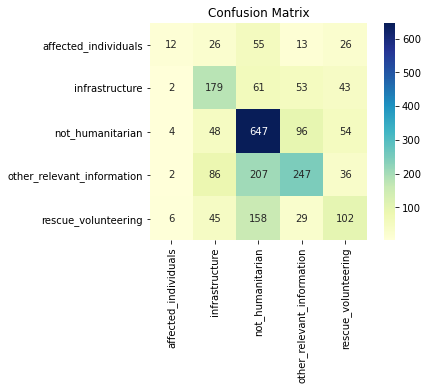

In [43]:
import seaborn as sns;

confusion = metrics.confusion_matrix(true_labels, predictions)


ticks = ['affected_individuals', 'infrastructure',
         'not_humanitarian', 'other_relevant_information',
         'rescue_volunteering']

plt.title('Confusion Matrix')
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", square=True,
                 xticklabels=ticks, yticklabels=ticks)

In [44]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))

13608 2237 2237


In [45]:
metrics.accuracy_score(true_labels, predictions)

0.5306213679034422

In [46]:
metrics.f1_score(true_labels, predictions, average='macro')

0.42558508387491745

In [47]:
metrics.precision_score(true_labels, predictions, average='macro')

0.4911994786991804

In [48]:
metrics.recall_score(true_labels, predictions, average='macro')

0.4219807113909524

## Extract Last Layer Feature

In [49]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [56]:
model.fc

Linear(in_features=512, out_features=5, bias=True)

In [50]:
class ImageDatasetExtract(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        tid = self.file_df.iloc[idx, 1]
        
        return image, label, tid

In [58]:
files = ['../sverma324/data/crisis-mmd/task_humanitarian_text_img_train.tsv','../sverma324/data/crisis-mmd/task_humanitarian_text_img_dev.tsv','../sverma324/data/crisis-mmd/task_humanitarian_text_img_test.tsv']

for file in files:
    df = pd.read_csv(file,sep='\t')
    df = df.loc[df.label_text_image=="Positive"]
    df.to_csv(file[:-4]+"_sub"+".tsv",sep='\t',index=False)


In [51]:
ls ../sverma324/data/crisis-mmd/

data_image/
Readme.txt
task_damage_text_img_dev.tsv
task_damage_text_img_test.tsv
task_damage_text_img_train.tsv
task_humanitarian_text_img_dev.pkl
task_humanitarian_text_img_dev_sub.tsv
task_humanitarian_text_img_dev.tsv
task_humanitarian_text_img_test.pkl
task_humanitarian_text_img_test_sub.tsv
task_humanitarian_text_img_test.tsv
task_humanitarian_text_img_train.pkl
task_humanitarian_text_img_train_sub.tsv
task_humanitarian_text_img_train.tsv
task_informative_text_img_dev.tsv
task_informative_text_img_test.tsv
task_informative_text_img_train.tsv


In [52]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract('../sverma324/data/crisis-mmd/task_humanitarian_text_img_train_sub.tsv',
                             '../sverma324/data/crisis-mmd')
dev_dataset = ImageDatasetExtract('../sverma324/data/crisis-mmd/task_humanitarian_text_img_dev_sub.tsv',
                             '../sverma324/data/crisis-mmd')
test_dataset = ImageDatasetExtract('../sverma324/data/crisis-mmd/task_humanitarian_text_img_test_sub.tsv',
                             '../sverma324/data/crisis-mmd')

In [53]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [54]:
ls

data/                              pace-jupyter-notebook.pbs.e556707
image-classification-Copy1.ipynb   pace-jupyter-notebook.pbs.e556711
image-classification.ipynb*        pace-jupyter-notebook.pbs.e556716
image_model_ouputs/                pace-jupyter-notebook.pbs.o551672
logs/                              pace-jupyter-notebook.pbs.o551708
Multimodal_final-Hindi.ipynb       pace-jupyter-notebook.pbs.o551709
Multimodal_final.ipynb             pace-jupyter-notebook.pbs.o551774
Multimodal.ipynb                   pace-jupyter-notebook.pbs.o551831
pace-jupyter-notebook.pbs*         pace-jupyter-notebook.pbs.o556564
pace-jupyter-notebook.pbs.e551672  pace-jupyter-notebook.pbs.o556572
pace-jupyter-notebook.pbs.e551708  pace-jupyter-notebook.pbs.o556583
pace-jupyter-notebook.pbs.e551709  pace-jupyter-notebook.pbs.o556598
pace-jupyter-notebook.pbs.e551774  pace-jupyter-notebook.pbs.o556607
pace-jupyter-notebook.pbs.e551831  pace-jupyter-notebook.pbs.o556657
pace-jupyter-notebook.pbs.e556564 

In [55]:
layer = model._modules.get('avgpool')

In [65]:
output_512 = []
output_512_tid = []

In [66]:
def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_512.append(cur_output[i, :])


layer.register_forward_hook(get_output)

In [67]:
model.training

True

In [68]:
# for inputs, labels, tids in tqdm(test_dataset_loader): dev_dataset_loader
for inputs, labels, tids in tqdm(test_dataset_loader):

    inputs = inputs.to(device)
    labels = labels.to(device)
    output_512_tid.extend(tids.detach().cpu().numpy().tolist())

    outputs = model(inputs)

100%|██████████| 30/30 [00:04<00:00,  6.28it/s]


In [69]:
len(output_512_tid),len(output_512)

(955, 5730)

In [64]:
ls

image-classification-Copy1.ipynb   pace-jupyter-notebook.pbs.e556572
image-classification.ipynb*        pace-jupyter-notebook.pbs.o551672
image_model_ouputs/                pace-jupyter-notebook.pbs.o551708
pace-jupyter-notebook.pbs*         pace-jupyter-notebook.pbs.o551709
pace-jupyter-notebook.pbs.e551672  pace-jupyter-notebook.pbs.o551774
pace-jupyter-notebook.pbs.e551708  pace-jupyter-notebook.pbs.o551831
pace-jupyter-notebook.pbs.e551709  pace-jupyter-notebook.pbs.o556564
pace-jupyter-notebook.pbs.e551774  pace-jupyter-notebook.pbs.o556572
pace-jupyter-notebook.pbs.e551831  wstm/
pace-jupyter-notebook.pbs.e556564


In [45]:
len(output_512)

18378

In [37]:
np.savez_compressed('image_model_ouputs/resnet18_image_embedding_512_train.npz',
                    image_embedding=output_512,
                    image_tweetID=output_512_tid)

In [100]:
output_512[0]

array([[2.187953]], dtype=float32)

In [ ]:
print(len(output_256_tid), len(output_256))

2237 2237


In [ ]:
np.savez_compressed('./data/image_embedding_256_dev.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [ ]:
print(len(output_256_tid), len(output_256))

13608 13608


In [ ]:
np.savez_compressed('./data/image_embedding_256_train.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [ ]:
tt = np.load('./data/image_embedding_256_test.npz')

In [ ]:
tt['image_embedding'].shape

(2237, 256)

In [ ]:
tt['image_tweetID'].shape

(2237,)

## Extract Classification Probabilities

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

In [ ]:
class ImageDatasetExtract(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        tid = self.file_df.iloc[idx, 1]
        
        return image, label, tid

In [ ]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')
dev_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             './data/crisis-mmd')
test_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             './data/crisis-mmd')

In [ ]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [ ]:
# Test set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

100%|██████████| 70/70 [00:08<00:00,  8.27it/s]


In [ ]:
np.savez_compressed('./data/image_predict_probs_test.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

In [ ]:
# Training set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/image_predict_probs_train.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

 83%|████████▎ | 354/426 [00:42<00:09,  7.31it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 426/426 [00:51<00:00,  8.33it/s]


In [ ]:
# Developing set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/image_predict_probs_dev.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

 13%|█▎        | 9/70 [00:01<00:16,  3.63it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 70/70 [00:08<00:00,  8.37it/s]


In [ ]:
len(test_probs_tids)

13608

In [ ]:
data = np.load('./data/image_predict_probs_test.npz')
print(data['predict_probs'].shape)
print(data['image_tweetID'].shape)

(2237, 5)
(2237,)


## MMHS150K Dataset

### 1. Train the Model

In [ ]:
from json import load, dump

In [ ]:
labels = load(open('./MMHS150K_GT.json', 'r'))

In [ ]:
binary_labels = {}

for k in labels:
    binary_labels[k] = int(labels[k]['labels'].count(0) <= 1)

In [ ]:
splits = {}

for name in ['train', 'val', 'test']:
    with open('./splits/{}_ids.txt'.format(name)) as fp:
        lines = [l.replace('\n', '') for l in fp.readlines()]
        splits[name] = lines

In [ ]:
Counter([binary_labels[k] for k in binary_labels])

Counter({1: 36978, 0: 112845})

In [ ]:
sub_labels = {'train': [], 'val': [], 'test': []}

for n in ['train', 'val', 'test']:
    for l in splits[n]:
        sub_labels[n].append(binary_labels[l])

(array([105346.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  29477.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

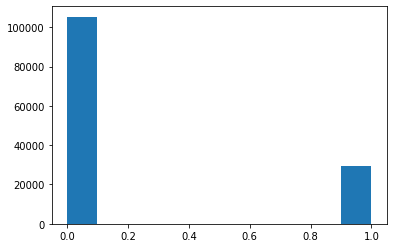

In [ ]:
plt.hist(sub_labels['train'])

In [ ]:
def image_transform(image):

    h, w, _ = image.shape
    target_len = 299
    padded_image = np.zeros((target_len, target_len, 3)).astype(int)


    if w > h:
        # Resize to [] x 299
        image = cv2.resize(image, (target_len, math.floor(h / (w / target_len))))
        short_len = image.shape[0]

        # Pad to 299 x 299
        padded_image[math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :, :] = image
    else:
        # Resize to 299 x []
        image = cv2.resize(image, (math.floor(w / (h / target_len)), target_len))
        short_len = image.shape[1]

        # Pad to 299 x 299
        padded_image[:, math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :] = image
    
    return padded_image

image = cv2.imread('./mmhs150k-img/{}.jpg'.format('1114679353714016256'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

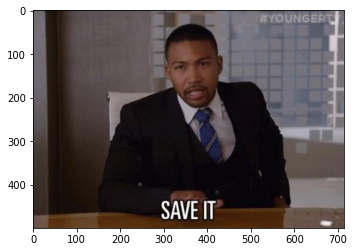

In [ ]:
plt.imshow(image)
plt.show()

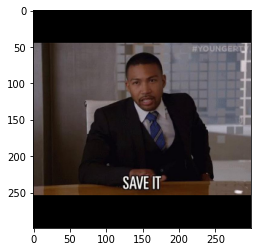

In [ ]:
plt.imshow(image_transform(image))
plt.show()

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        return image, label

In [ ]:
train_dataset = ImageDataset(splits['train'], './mmhs150k-img')

In [ ]:
for i in train_dataset:
    print(i[0].shape, i[1])
    break

torch.Size([3, 224, 224]) 1


In [ ]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDataset(splits['train'], './mmhs150k-img')
dev_dataset = ImageDataset(splits['val'], './mmhs150k-img')
test_dataset = ImageDataset(splits['test'], './mmhs150k-img')

In [ ]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [ ]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, torch.max(inputs), labels)
    break

torch.Size([32, 3, 224, 224]) tensor(2.6400) tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0])


In [ ]:
torch.Tensor([1,2])

tensor([1., 2.])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=20):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_predicts = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                running_predicts.extend(preds.tolist())
                running_labels.extend(labels.data.tolist())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                # Compute F1 score
                y_true = torch.Tensor(running_labels)
                y_pred = torch.Tensor(running_predicts)
                tp = (y_true * y_pred).sum().to(torch.float32)
                tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
                fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
                fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

                epsilon = 1e-7

                precision = tp / (tp + fp + epsilon)
                recall = tp / (tp + fn + epsilon)

                f1 = 2 * (precision*recall) / (precision + recall + epsilon)
                
                print(f1)
    
                if f1 > best_f1:
                    best_f1 = f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [42]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()

/storage/home/hcocice1/sarora320/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# dataloaders = {'train': train_dataset_loader,
#                'val': dev_dataset_loader}

# model, val_acc_history = train_model(model, dataloaders, criterion,
#                                      optimizer_ft, num_epochs=200,
#                                      patience=30)

# #torch.save(model.state_dict(), './output/best_weights_mmhs150k.pk')
# # dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

## 3. Analysis

In [ ]:
num_classes = 2
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [ ]:
batch_size = 32

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [ ]:
predictions = []
true_labels = []
criterion = nn.CrossEntropyLoss()

for inputs, labels in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    
    predictions.extend(preds.cpu().numpy().tolist())
    true_labels.extend(labels.cpu().numpy().tolist())


100%|██████████| 313/313 [00:23<00:00, 13.16it/s]


In [ ]:
confusion = metrics.confusion_matrix(true_labels, predictions)

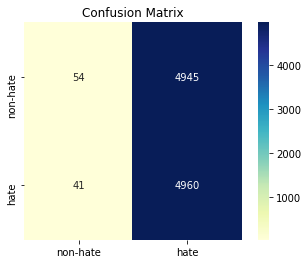

In [ ]:
import seaborn as sns;

ticks = ['non-hate', 'hate']

plt.title('Confusion Matrix')
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", square=True,
                 xticklabels=ticks, yticklabels=ticks)

In [ ]:
Counter(predictions)

Counter({1: 9907, 0: 93})

In [ ]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))

134823 5000 10000


In [ ]:
metrics.accuracy_score(true_labels, predictions)

0.5008

In [ ]:
metrics.f1_score(true_labels, predictions)

0.6651462302119667

In [ ]:
metrics.precision_score(true_labels, predictions)

0.5004542242858585

In [ ]:
metrics.recall_score(true_labels, predictions)

0.9914017196560688

## Extract Last Layer Feature

In [ ]:
model.classifier._modules['6'][0]
model.classifier._modules['3']

Linear(in_features=4096, out_features=4096, bias=True)

In [ ]:
class ImageDatasetExtract(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        tid = self.ids[idx]
        
        return image, label, tid

In [ ]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract(splits['train'], 'mmhs150k-img')
dev_dataset = ImageDatasetExtract(splits['val'], 'mmhs150k-img')
test_dataset = ImageDatasetExtract(splits['test'], 'mmhs150k-img')

In [ ]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [ ]:
output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

In [ ]:
for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


In [ ]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_test.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

100%|██████████| 157/157 [00:11<00:00, 13.16it/s]


In [ ]:
print(len(output_256_tid), len(output_256))

5000 5000


In [ ]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_dev.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

 22%|██▏       | 945/4214 [01:10<03:58, 13.71it/s]Traceback (most recent call last):
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
100%|██████████| 4214/4214 [05:11<00:00, 13.55it/s]


In [ ]:
print(len(output_256_tid), len(output_256))

134823 134823


In [ ]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_train.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [ ]:
tt = np.load('./data/mmhs150k_image_embedding_256_test.npz')

In [ ]:
print(tt['image_embedding'].shape)
print(tt['image_tweetID'].shape)

(10000, 256)
(10000,)


## Extract Classification Probabilities

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [ ]:
class ImageDatasetExtract(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        tid = self.ids[idx]
        
        return image, label, tid

In [ ]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract(splits['train'], 'mmhs150k-img')
dev_dataset = ImageDatasetExtract(splits['val'], 'mmhs150k-img')
test_dataset = ImageDatasetExtract(splits['test'], 'mmhs150k-img')

In [ ]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [ ]:
# Test set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


In [ ]:
np.savez_compressed('./data/mmhs150k_image_predict_probs_test.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

In [ ]:
# Training set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/mmhs150k_image_predict_probs_train.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

100%|██████████| 4214/4214 [05:07<00:00, 13.69it/s]


In [ ]:
# Developing set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/mmhs150k_image_predict_probs_dev.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

100%|██████████| 157/157 [00:11<00:00, 13.32it/s]


In [ ]:
len(test_probs_tids)

13608

In [ ]:
data = np.load('./data/mmhs150k_image_predict_probs_test.npz')
print(data['predict_probs'].shape)
print(data['image_tweetID'].shape)

(10000, 2)
(10000,)


## Fake Image Dataset

In [ ]:
import urllib.request

# urllib.request.urlretrieve("http://www.digimouth.com/news/media/2011/09/google-logo.jpg", "local-filename.jpg")

In [ ]:
img_df = pd.read_csv('./verification/set_images.txt', sep='\t')

In [ ]:
img_df.head()

,image_id,image_url,annotation,event
0,boston_fake_01,http://i.imgur.com/LvoCC5T.jpg,fake,boston
1,boston_fake_02,http://instagram.com/p/YN7_ThPXrU/,fake,boston
2,boston_fake_03,https://o.twimg.com/2/proxy.jpg?t=HBgeaHR0cDov...,fake,boston
3,boston_fake_04,http://media.tumblr.com/a813460e72a178d8127b50...,fake,boston
4,boston_fake_05,http://i.imgur.com/uxAh4wwh.jpg,fake,boston


In [ ]:
img_df['image_url']

0                         http://i.imgur.com/LvoCC5T.jpg
1                     http://instagram.com/p/YN7_ThPXrU/
2      https://o.twimg.com/2/proxy.jpg?t=HBgeaHR0cDov...
3      http://media.tumblr.com/a813460e72a178d8127b50...
4                        http://i.imgur.com/uxAh4wwh.jpg
                             ...                        
394      https://pbs.twimg.com/media/Bic4fA5CQAAT5KY.jpg
395      https://pbs.twimg.com/media/BialJuECIAATXE2.jpg
396      https://pbs.twimg.com/media/BiVisqpCIAAbgju.jpg
397      https://pbs.twimg.com/media/Bo-CY5ACcAAiRAw.jpg
398      https://pbs.twimg.com/media/BpJguJhIMAAQsZK.jpg
Name: image_url, Length: 399, dtype: object

In [ ]:
img_df.shape

(399, 4)

In [ ]:
for i, row in img_df.iterrows():
    try:
        urllib.request.urlretrieve(row['image_url'], './verification/imgs/{}.jpg'.format(row['image_id']))
    except:
        pass